# Character Level Language Model Using LSTM

Purpose of this excercise is to build a character level language model based on the GRU model with pytorch. The model follows the char-rnn-karpathy model. The model is trained on the text of the book "The lord of the rings". The model is trained on the GPU.

The overall concept is that individual characters are embedded into a vector space size [batch, seq_length, hidden_space]. The embedding is then fed into a GRU cell. The output of the GRU cell is then fed into a fully connected layer. The output of the fully connected layer is then fed into a softmax layer. The softmax layer then predicts the next character based on argmax.

The model is trained on a sequence of characters. The sequence is then shifted by one character and the model is trained again.

Reference:

Karpathy, A. (2015). The Unreasonable Effectiveness of Recurrent Neural Networks. Retrieved from http://karpathy.github.io/2015/05/21/rnn-effectiveness/ 

In [1]:
import string
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Tuple, List, Dict
from torch.utils.data import Dataset, DataLoader

## Preprocessing the data

In [2]:
def load_text(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    return text

def clean_text(text):
    return ''.join(filter(lambda x: x in string.printable, text))

In [3]:
def random_chunk(text: str, chunk_len: int = 200):
  start_index = random.randint(0, len(text) - chunk_len - 1)
  end_index = start_index + chunk_len + 1
  return text[start_index:end_index]

# Turn string into list of longs
def tokenizer(string: str, vocab: List[str]):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = vocab.index(string[c])
  return tensor

def detokenizer(tensor: torch.Tensor, vocab: List[str]):
  string = ""
  for t in tensor:
    string += vocab[t]
  return string

def random_training_set(text: str, vocab: List[str], chunk_len: int = 200): 
  chunk = random_chunk(text, chunk_len)
  input_seq = tokenizer(chunk[:-1], vocab)
  target = tokenizer(chunk[1:], vocab)
  return input_seq, target

In [4]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len):
        self.text = text
        self.chunk_len = chunk_len
        self.vocab = list(string.printable)
        self.vocab_size = len(self.vocab)
        self.char_to_idx = {char: idx for idx, char in enumerate(self.vocab)}

    def __len__(self):
        return len(self.text) // self.chunk_len

    def __getitem__(self, idx):
        start_index = idx * self.chunk_len
        end_index = start_index + self.chunk_len + 1
        chunk = random_chunk(self.text[start_index:end_index], self.chunk_len)
        input_seq = torch.tensor([self.char_to_idx[char] for char in chunk[:-1]], dtype=torch.long)
        target_seq = torch.tensor([self.char_to_idx[char] for char in chunk[1:]], dtype=torch.long)
        return input_seq, target_seq

In [5]:
# use regex to remove all non-ascii and non-printable characters
text_raw = load_text('datasets/rnn_dataset/phoenix_suns_history.txt')
text_clean = clean_text(text_raw)
vocab = list(string.printable)

In [ ]:
# get batch_size number of random chunks
def get_random_batch(text: str, vocab: List[str], batch_size: int, chunk_len: int = 200):
  input_seqs = []
  target_seqs = []
  for _ in range(batch_size):
    input_seq, target_seq = random_training_set(text, vocab, chunk_len)
    input_seqs.append(input_seq)
    target_seqs.append(target_seq)
  return torch.stack(input_seqs), torch.stack(target_seqs)

In [6]:
chunk_len = 500
dataset_train = TextDataset(text=text_clean, chunk_len=chunk_len)
dataloader_train = DataLoader(dataset_train, batch_size=10, shuffle=True)

In [7]:
batch = next(iter(dataloader_train))
x, y = batch
print(f"Batch Input Shape: {x.shape}")
print(f"Batch Target Shape: {y.shape}")
print(x[0])
print(detokenizer(x[0], dataset_train.vocab))
print(y[0])
print(detokenizer(y[0], dataset_train.vocab))

Batch Input Shape: torch.Size([3, 500])
Batch Target Shape: torch.Size([3, 500])
tensor([55, 17, 14, 94, 51, 17, 24, 14, 23, 18, 33, 94, 54, 30, 23, 28, 94, 10,
        27, 14, 94, 10, 23, 94, 36, 22, 14, 27, 18, 12, 10, 23, 94, 25, 27, 24,
        15, 14, 28, 28, 18, 24, 23, 10, 21, 94, 11, 10, 28, 20, 14, 29, 11, 10,
        21, 21, 94, 29, 14, 10, 22, 94, 11, 10, 28, 14, 13, 94, 18, 23, 94, 51,
        17, 24, 14, 23, 18, 33, 73, 94, 36, 27, 18, 35, 24, 23, 10, 75, 94, 55,
        17, 14, 94, 54, 30, 23, 28, 94, 12, 24, 22, 25, 14, 29, 14, 94, 18, 23,
        94, 29, 17, 14, 94, 49, 10, 29, 18, 24, 23, 10, 21, 94, 37, 10, 28, 20,
        14, 29, 11, 10, 21, 21, 94, 36, 28, 28, 24, 12, 18, 10, 29, 18, 24, 23,
        94, 69, 49, 37, 36, 70, 73, 94, 10, 28, 94, 10, 94, 22, 14, 22, 11, 14,
        27, 94, 24, 15, 94, 29, 17, 14, 94, 21, 14, 10, 16, 30, 14, 68, 28, 94,
        58, 14, 28, 29, 14, 27, 23, 94, 38, 24, 23, 15, 14, 27, 14, 23, 12, 14,
        94, 51, 10, 12, 18, 15, 18, 12,

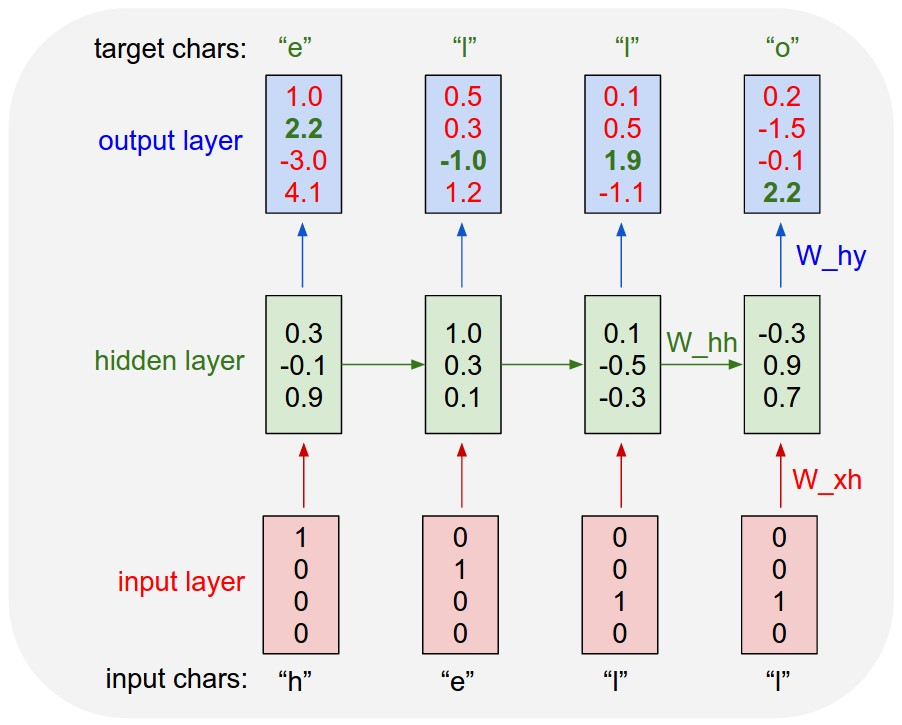

## Creating the model

In [8]:
class RNN(nn.Module):
  def __init__(self, seq_len:int, embed_dim:int, vocab_size:int, n_layers:int = 1):
    super().__init__()
    self.seq_len = seq_len
    self.embed_dim = embed_dim
    self.embedding = nn.Embedding(seq_len, embed_dim)
    self.gru = nn.GRU(input_size=embed_dim, hidden_size=embed_dim, num_layers=n_layers)
    self.fc1 = nn.Linear(embed_dim, vocab_size)

  def forward(self, x, hidden):
    x = self.embedding(x)
    x, hidden = self.gru(x, hidden)
    x = self.fc1(x.reshape(-1, self.embed_dim))
    return x, hidden

  def init_hidden(self, seq_len:int = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if seq_len is None:
      a = torch.zeros(1, self.seq_len, self.embed_dim).to(device)
    else:
      a = torch.zeros(1, seq_len, self.embed_dim).to(device)
    return a

In [9]:
# x_test = x[0].unsqueeze(0)
# x_test.shape

# embedding = nn.Embedding(500, 200)
# x_test2 = embedding(x_test)
# x_test2.shape

# gru = nn.GRU(input_size=200, hidden_size=200, num_layers=1)
# hidden = torch.zeros(1, chunk_len, 200)
# output, hidden = gru(x_test2, hidden)
# output.shape, hidden.shape

# fc1 = nn.Linear(200, dataset_train.vocab_size)
# output = fc1(output.reshape(-1, 200))
# output.shape

# model = RNN(input_size=chunk_len, output_size=100, hidden_size=200, n_layers=1).to('cpu')
# hidden_state = model.init_hidden(batch_size=1, seq_len=chunk_len).to('cpu')
# hidden_state.shape

# model(x_test, hidden_state)

## Training the model

In [10]:
def train_classification(model: nn.Module, data_loader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, device: torch.device):
  model.train().to(device)
  epoch_loss = 0
  for x, y in data_loader:
      x, y = x.to(device), y.to(device)
      hidden = model.init_hidden().to(device)
      optimizer.zero_grad()
      logits, _ = model(x, hidden)
      logits_flat = logits.view(-1, logits.size(-1))
      labels_flat = y.view(-1)
      loss = criterion(logits_flat, labels_flat)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
  return epoch_loss / len(data_loader)

In [11]:
def predict(model:RNN, vocabulary:List[str], device: torch.device, primer:str='A', predict_len:int=100, temperature:float=0.8):
    model.eval().to(device)
    primer_tokens = tokenizer(primer, vocabulary).to(device)
    # print("Primer Tokens: ", primer_tokens)
    # print("Primer Tokens Shape: ", primer_tokens.shape)

    hidden_state = model.init_hidden(seq_len=1).squeeze(0).to(device)
    #print("Hidden State: ", hidden_state.shape)

    prediction = primer
    #print("Prediction: ", prediction)
    
    with torch.no_grad():
      for char in range(len(primer) - 1):
        single_token = primer_tokens[char].unsqueeze(0)
        # print("Single Token: ", single_token)
        # print("Single Token Shape: ", single_token.shape)
        _, hidden_state = model(single_token, hidden_state)
      input_seq = primer_tokens[-1].unsqueeze(0)
      # print("Input Seq: ", input_seq)
      # print("Input Seq Shape: ", input_seq.shape)

      for _ in range(predict_len):
        output, _ = model(input_seq, hidden_state)
        output = output.to(device)
        sampled_character = sample_outputs(output.view(-1), temperature)
        char_choice = vocabulary[sampled_character]
        input_seq = torch.tensor([vocabulary.index(char_choice)], dtype=torch.long).to(device)
        prediction += char_choice
    return prediction

def sample_outputs(output, temperature):
  """Takes in a vector of unnormalized probability weights and samples a character from the distribution"""
  return torch.multinomial(torch.exp(output) / temperature, 1)

In [12]:
# Lists to keep track of loss and generate plot
train_loss = []

# Training Hyperparameters
n_epochs = 10000
print_every = 500
seq_len = chunk_len
embed_dim = 200
vocab_size = dataset_train.vocab_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# instantiate model, loss function and optimizer
model = RNN(seq_len=seq_len, embed_dim=embed_dim, vocab_size=vocab_size, n_layers=1).to(device)
critierion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
# Training Loop
for epoch in tqdm(range(n_epochs), desc='Training Progress'):
  epoch_train_loss = train_classification(model=model,data_loader=dataloader_train, optimizer=optimizer, criterion=critierion, device=device)
  train_loss.append(epoch_train_loss)
  if epoch % print_every == 0:
    print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} \n')
    print(
      predict(model=model, vocabulary=vocab, device=device, primer='Wh', predict_len=100, temperature=0.8),
        '\n',
      )

Training Progress:   0%|          | 44/10000 [00:00<00:50, 196.14it/s]

[1/10000] Train loss: 4.6250 

w	?C4*|zA6
`<\)D~nKKKt>`oGCc?@fA7XCV{At%<LEL<|F/*/Pki=O;!pik] Q>}D5|U:ewJi[uGMadD(^hl='k{9et.k 



Training Progress:   6%|▌         | 560/10000 [00:01<00:23, 395.70it/s]

[501/10000] Train loss: 2.2337 

Whameth, Balthe iyre iowon winon Theed Asere c Fwer x Fd Hte perers cohe te f are 19ler Wl Nar iorpjf  



Training Progress:  10%|█         | 1029/10000 [00:02<00:23, 376.62it/s]

[1001/10000] Train loss: 1.9425 

Whaf amed th, istin 19988is inthe bamem Dverion BAricoun m), tohens ired Pacheayiarelse tend fthe Jonn 



Training Progress:  15%|█▌        | 1534/10000 [00:03<00:21, 388.48it/s]

[1501/10000] Train loss: 1.7483 

Whe itheaname Va as an 198 ricid tped 20s fond ither inadirais hithebio am itherthe =oheguay, amalyont 



Training Progress:  21%|██        | 2063/10000 [00:05<00:19, 404.50it/s]

[2001/10000] Train loss: 1.6245 

Wheitsid ins ans ants ss tsiarite aithethe's itowis amithoas 20ss titomis ayed ajede<Naists amameirs,  



Training Progress:  25%|██▌       | 2524/10000 [00:06<00:21, 342.75it/s]

[2501/10000] Train loss: 1.4417 

Whesserl d a itse ay amed asshed amstss irisssiss ans r's Therix amiteiocqun irs ameassis as andirts m 



Training Progress:  30%|███       | 3024/10000 [00:07<00:21, 321.70it/s]

[3001/10000] Train loss: 1.4340 

Whisisstsheritheis amas its am iris asitsansheisss its iss Pas ammis irs irshegePhe a irstitss ame asi 



Training Progress:  36%|███▌      | 3550/10000 [00:09<00:19, 334.99it/s]

[3501/10000] Train loss: 1.3582 

Whedilonsthe ampam, ambuts aisis ars a as amediodam ams as as isims as am amas as as am am ams ay asts 



Training Progress:  40%|████      | 4046/10000 [00:10<00:17, 333.70it/s]

[4001/10000] Train loss: 1.3715 

Whed assinsis its as ass amitbam, ams aje ay am as ay as a ajautsisisheseists amamed am, asisss amed a 



Training Progress:  45%|████▌     | 4539/10000 [00:12<00:16, 340.40it/s]

[4501/10000] Train loss: 1.2907 

Whe ases as asts asshed asss iststs arits as is asts asis aitsed iouts am as as ambadis ajed amstsshed 



Training Progress:  50%|█████     | 5045/10000 [00:13<00:14, 340.03it/s]

[5001/10000] Train loss: 1.2793 

Whed anststs amitss a ajoutss ams he adis as ame is ampa ajod isis asts am aje als a as aseits ampajod 



Training Progress:  55%|█████▌    | 5547/10000 [00:14<00:13, 333.99it/s]

[5501/10000] Train loss: 1.3192 

Whembajod ams ass am amis as as ished alis ammastsis amis ambase am ams as am ambis ambam an anstsiout 



Training Progress:  60%|██████    | 6045/10000 [00:16<00:11, 348.63it/s]

[6001/10000] Train loss: 1.2777 

Whers ad ans ashe ame is asitsis am amsitssis ame ame amas ampambuged am astsits as a asisitshe ansss  



Training Progress:  65%|██████▌   | 6533/10000 [00:17<00:11, 314.83it/s]

[6501/10000] Train loss: 1.3043 

Whampas ammeas amed asss as amsissts ams amits ansitshed as ambas am a a ameits am as am as amirs as a 



Training Progress:  70%|███████   | 7028/10000 [00:18<00:09, 323.56it/s]

[7001/10000] Train loss: 1.2936 

Whedis itsis am ameas amedits as ass amiss amis asts am a ans as ambas assitsts amed itoha am ajoun an 



Training Progress:  75%|███████▌  | 7533/10000 [00:20<00:07, 327.78it/s]

[7501/10000] Train loss: 1.3234 

Whe am as asersss its a. acquts ad amed ishambas amems asised ammed as ampitsts ans as am as ass asis  



Training Progress:  80%|████████  | 8028/10000 [00:21<00:05, 329.67it/s]

[8001/10000] Train loss: 1.3065 

Whamss as a astshed as ambis as am as as am as as ansis am amis amed am as asid ished ay am ay ans ans 



Training Progress:  85%|████████▌ | 8524/10000 [00:23<00:04, 315.92it/s]

[8501/10000] Train loss: 1.2964 

Whams am ashed ame ame's am ashe am is am as ambamists as as ams ampis its amits as amis amba as as an 



Training Progress:  90%|█████████ | 9035/10000 [00:24<00:02, 323.10it/s]

[9001/10000] Train loss: 1.2477 

Whed as am as ampis as ams as am amame amans amed ajoame am ashed is ans am am amed a as ais a ams ama 



Training Progress:  95%|█████████▌| 9532/10000 [00:25<00:01, 313.88it/s]

[9501/10000] Train loss: 1.2941 

Whe as ambamemed ambas ambis ambais ams amis amid amas aje amis as as asts as as as as asirisis as as  



Training Progress: 100%|██████████| 10000/10000 [00:27<00:00, 367.63it/s]


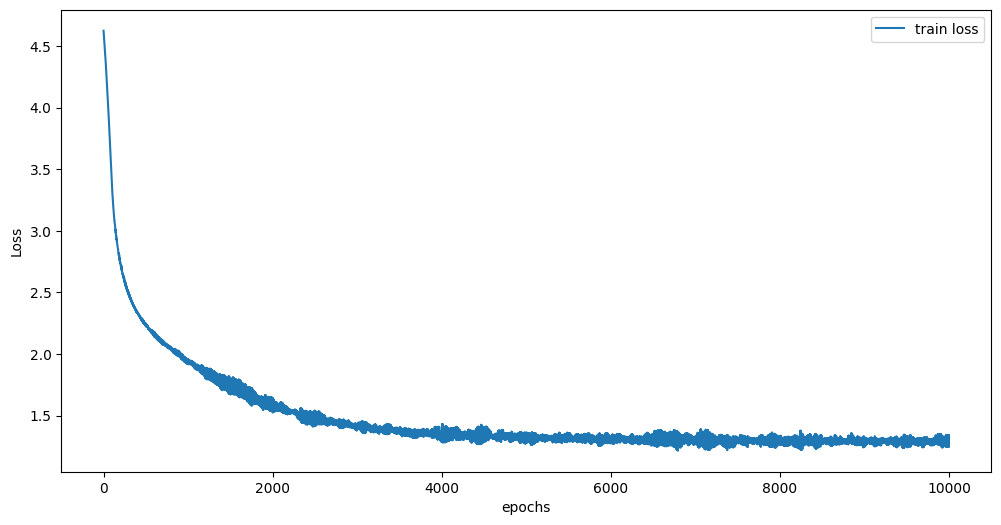

In [14]:
# Plot the training loss
fig, ax1 = plt.subplots(1, figsize=(12, 6), sharex=True)
ax1.plot(train_loss, label="train loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("epochs")
ax1.legend()

## Inference

In [15]:
start_strings = ["Th", " wh", " he", " I ", " ca", " We", " lo", " ra"]
for primer in start_strings:
  print(predict(model=model, vocabulary=vocab, device=device, primer=primer, predict_len=100, temperature=0.8), '\n')

Thedirin f rin f f f f f rin f wincof rincquncqun rin f f f f fonconchedinchedix, f rinched fririn f f 

 wh tememempemem tem Alion Am Alitem Amem tem Alion tem Amemempionononon temememememempion Arem Ampemem 

 he t Hof Hof of Pane t t Hof Hof Hof Hof t t t Ine Na t t of Pa of Pa t of Ie t Hof t of Pacof t of t  

 I the thend thed theme thand the the thenshe these the thed thanshenthe the thenshe theche thed than t 

 campe amper, Pal wer, wer, we anir, wer, wer, Pamputer, ar, wir, we wer, we Pas anir, ampl Pa. wer, we 

 Weits am iconsis ansits arinsis isitsis is inirinits ts in ithed isis iriririteguniseits is is ithed i 

 lon m m m m m m tin m m m teran m t t m t ter tiler m ter m m m on m t m t t teran t teran m t t m m t 

 ra. iont Cont C Cont Sut ionte Suntedededeantyededea. iont t ionthea. Cont p, pwea. Contedearedearte C 

